## Distributed Strategy

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf

In [11]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


In [12]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [13]:
# Build the model using the functional API
def create_model():
  i = Input(shape=x_train[0].shape)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(K, activation='softmax')(x)

  model = Model(i, x)
  return model

In [14]:
strategy = tf.distribute.MirroredStrategy()
# strategy = tf.distribute.experimental.CentralStorageStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [15]:
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 1


In [16]:
with strategy.scope():
  model = create_model()

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [17]:
# Fit
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 128, epochs=15)

Epoch 1/15
391/391 [==============================] - 16s 41ms/step - accuracy: 0.5320 - loss: 1.3962 - val_accuracy: 0.2478 - val_loss: 2.8568
Epoch 2/15
391/391 [==============================] - 15s 37ms/step - accuracy: 0.7042 - loss: 0.8397 - val_accuracy: 0.6910 - val_loss: 0.9106
Epoch 3/15
391/391 [==============================] - 15s 38ms/step - accuracy: 0.7726 - loss: 0.6523 - val_accuracy: 0.7505 - val_loss: 0.7233
Epoch 4/15
391/391 [==============================] - 15s 37ms/step - accuracy: 0.8098 - loss: 0.5412 - val_accuracy: 0.7680 - val_loss: 0.6916
Epoch 5/15
391/391 [==============================] - 15s 37ms/step - accuracy: 0.8423 - loss: 0.4521 - val_accuracy: 0.7905 - val_loss: 0.6403
Epoch 6/15
391/391 [==============================] - 15s 37ms/step - accuracy: 0.8685 - loss: 0.3788 - val_accuracy: 0.7860 - val_loss: 0.6471
Epoch 7/15
391/391 [==============================] - 15s 37ms/step - accuracy: 0.8931 - loss: 0.3069 - val_accuracy: 0.7824 - val_loss:

In [18]:
# Compare this to non-distributed training
model2 = create_model()
model2.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3052 - accuracy: 0.5495 - val_loss: 0.9000 - val_accuracy: 0.6864
Epoch 2/5
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8406 - accuracy: 0.7075 - val_loss: 0.8059 - val_accuracy: 0.7246
Epoch 3/5
1563/1563 [==============================] - 25s 16ms/step - loss: 0.6870 - accuracy: 0.7629 - val_loss: 0.8168 - val_accuracy: 0.7312
Epoch 4/5
1563/1563 [==============================] - 25s 16ms/step - loss: 0.5782 - accuracy: 0.8025 - val_loss: 0.6287 - val_accuracy: 0.7886
Epoch 5/5
1563/1563 [==============================] - 25s 16ms/step - loss: 0.4929 - accuracy: 0.8317 - val_loss: 0.6583 - val_accuracy: 0.7819


## TPU

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [3]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape = X_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64,(5,5), padding='same', activation='selu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='selu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(256,(5,5), padding='same', activation='selu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation='elu'))
  model.add(tf.keras.layers.Dropout(0.38))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.42))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  return model

In [4]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])

INFO:tensorflow:Initializing the TPU system: grpc://10.99.72.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.99.72.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [6]:
model.fit(
    X_train.astype(np.float32), Y_train.astype(np.float32),
    epochs=17,
    steps_per_epoch=60,
    validation_data=(X_test.astype(np.float32), Y_test.astype(np.float32)),
    validation_freq=17
)

Epoch 1/17
60/60 [==============================] - 1s 16ms/step - sparse_categorical_accuracy: 0.6584 - loss: 1.0464
Epoch 2/17
60/60 [==============================] - 1s 15ms/step - sparse_categorical_accuracy: 0.8179 - loss: 0.5180
Epoch 3/17
60/60 [==============================] - 1s 16ms/step - sparse_categorical_accuracy: 0.8489 - loss: 0.4306
Epoch 4/17
60/60 [==============================] - 1s 16ms/step - sparse_categorical_accuracy: 0.8652 - loss: 0.3822
Epoch 5/17
60/60 [==============================] - 1s 15ms/step - sparse_categorical_accuracy: 0.8787 - loss: 0.3397
Epoch 6/17
60/60 [==============================] - 1s 16ms/step - sparse_categorical_accuracy: 0.8873 - loss: 0.3170
Epoch 7/17
60/60 [==============================] - 1s 16ms/step - sparse_categorical_accuracy: 0.8926 - loss: 0.2970
Epoch 8/17
60/60 [==============================] - 1s 16ms/step - sparse_categorical_accuracy: 0.9019 - loss: 0.2756
Epoch 9/17
60/60 [==============================] - 1s 1

In [7]:
model.save_weights('./fashion_mnist.h5', overwrite=True)

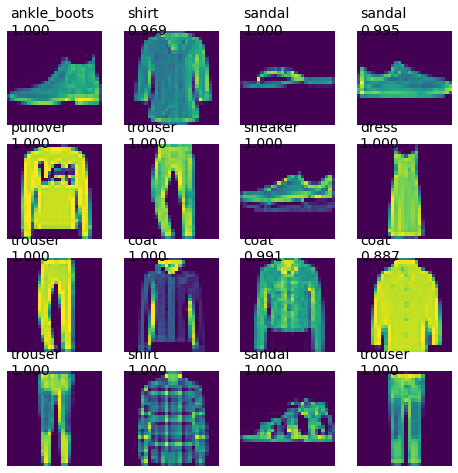

In [10]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


cpu_model = create_model()
cpu_model.load_weights('./fashion_mnist.h5')

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(X_test[:16]), cpu_model.predict(X_test[:16]))